# Gridding ecoregions and land cover estimates for CMIP5 model output common grid.  

TODO: I need a product that shows me the percent of land cover area within a CMIP5 model grid box. E.g., 40% grass, 20% forest, 40% shrubs. 

For now:

Data source: http://glcf.umd.edu/data/lc/

On the data grid:

"Global Mosaics of the standard MODIS land cover type data product (MCD12Q1) in the IGBP Land Cover Type Classification are reprojected into geographic coordinates of latitude and longitude on the WGS 1984 coordinate reference system (EPSG: 4326). The data set boundaries are -180.0° <= longitude <= 180.0°; -64.0° <= latitude <= 84.0°. The data are organized as an array of values uniformly spaced across latitude and longitude with the indexed as [0, 0] at 84.0° latitude, -180.0° longitude."

TODO: Make nice table
Value	Label
0	Water
1	Evergreen Needleleaf forest
2	Evergreen Broadleaf forest
3	Deciduous Needleleaf forest
4	Deciduous Broadleaf forest
5	Mixed forest
6	Closed shrublands
7	Open shrublands
8	Woody savannas
9	Savannas
10	Grasslands
11	Permanent wetlands
12	Croplands
13	Urban and built-up
14	Cropland/Natural vegetation mosaic
15	Snow and ice
16	Barren or sparsely vegetated
254	Unclassified
255	Fill Value

In [37]:
import gdal
import os
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

dataDir = "LandCover"
f = os.path.join(dataDir, "LC_hd_global_2012.tif")
gtif = gdal.Open( f )
print gtif.GetMetadata()
data = np.array(gtif.GetRasterBand(1).ReadAsArray())
print data.shape

print np.unique(data)


{'TIFFTAG_DATETIME': '2012', 'TIFFTAG_IMAGEDESCRIPTION': '\n\tLand Cover Type - IGBP Classification\n\tValues: \n\t\t0-Water\n\t\t1-Evergreen Needleleaf forest\n\t\t2-Evergreen Broadleaf forest\n\t\t3-Deciduous Needleleaf forest\n\t\t4-Deciduous Broadleaf forest\n\t\t5-Mixed forest\n\t\t6-Closed shrublands\n\t\t7-Open shrublands\n\t\t8-Woody savannas\n\t\t9-Savannas\n\t\t10-Grasslands\n\t\t11-Permanent wetlands\n\t\t12-Croplands\n\t\t13-Urban and built-up\n\t\t14-Cropland/Natural vegetation mosaic\n\t\t15-Snow and ice\n\t\t16-Barren or sparsely vegetated\n\t\t254-Unclassified\n\t\t255-Fill Value', 'TIFFTAG_HOSTCOMPUTER': 'http://www.landcover.org/', 'TIFFTAG_ARTIST': '\n\tGlobal Land Cover Facility (GLCF) at University of Maryland\n\tPacific Northwest National Laboratory (PNNL)', 'AREA_OR_POINT': 'Area'}
(296, 720)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [33]:
# Get the coordinates 
width = gtif.RasterXSize
height = gtif.RasterYSize
gt = gtif.GetGeoTransform()

print width
print height
print type(gt)

minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

print minx
print maxx
print miny
print maxy

x = np.linspace(minx, maxx, data.shape[1])
y = np.linspace(maxy, miny, data.shape[0])

720
296
<type 'tuple'>
-180.0
180.0
-64.0
84.0


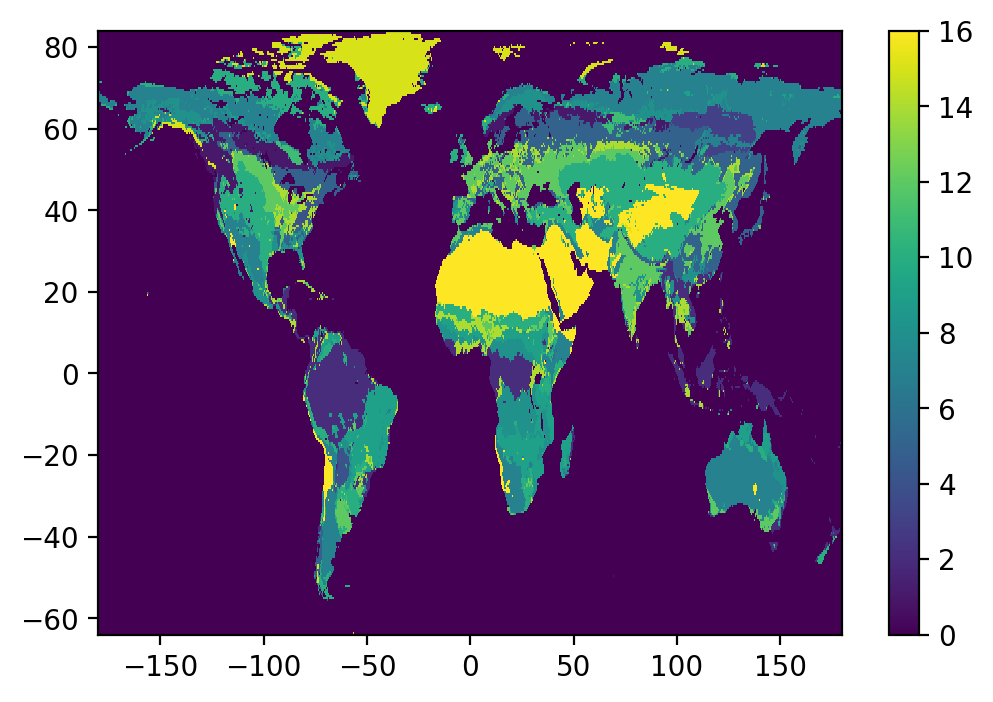

In [36]:
plt.figure(dpi=200)
plt.pcolor(x,y, data)
plt.colorbar()
plt.show()

### Save this as a netCDF file.


In [47]:
from netCDF4 import Dataset 

outputFile = os.path.join(dataDir, "out.nc")

ncFile = Dataset(outputFile, 'w', format='NETCDF4')
ncFile.description = 'Land cover'
ncFile.location = 'Global'
ncFile.createDimension('latitude', len(y) )
ncFile.createDimension('longitude', len(x) )

VAR_ = ncFile.createVariable("LC", 'f4',('latitude','longitude'))

# create lat variable
latitude_ = ncFile.createVariable('latitude', 'f4', ('latitude',))
latitude_.units = 'degrees_north'

# create longitude variable
longitude_ = ncFile.createVariable('longitude', 'f4', ('longitude',))
longitude_.units = 'degrees_east'

# Write the actual data to these dimensions
VAR_[:]       = data
latitude_[:]  = y
longitude_[:] = x

ncFile.close()

What does this look like regridded to a very course grid? These will be regridded via CDO remapbil

In [50]:
import subprocess
print os.getcwd()
os.system("cdo remapbil,COMMON_GRID.txt LandCover/out.nc lc.nc")

/Users/sbrey/GoogleDrive/sharedProjects/getCMIP5


32512

In [49]:
?subprocess.Popen

Init signature: subprocess.Popen(self, args, bufsize=0, executable=None, stdin=None, stdout=None, stderr=None, preexec_fn=None, close_fds=False, shell=False, cwd=None, env=None, universal_newlines=False, startupinfo=None, creationflags=0)
Docstring:     
Execute a child program in a new process.

For a complete description of the arguments see the Python documentation.

Arguments:
  args: A string, or a sequence of program arguments.

  bufsize: supplied as the buffering argument to the open() function when
      creating the stdin/stdout/stderr pipe file objects

  executable: A replacement program to execute.

  stdin, stdout and stderr: These specify the executed programs' standard
      input, standard output and standard error file handles, respectively.

  preexec_fn: (POSIX only) An object to be called in the child process
      just before the child is executed.

  close_fds: Controls closing or inheriting of file descriptors.

  shell: If true, the command will be executed thr